In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torchsummary import summary
from einops.layers.torch import Rearrange
from torch.utils.tensorboard import SummaryWriter
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torch.cuda.amp import GradScaler
from torchvision.utils import make_grid
import warnings
import os
import random
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
import tifffile as tiff
# 忽略所有警告
warnings.filterwarnings('ignore')

class CFG:
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    checpoint = 'result/UnetPlusPlus-DIM-22-[eval_loss]-0.2248-[dice_score]-0.82-30-epoch.pkl'
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # # comp_dir_path = './'
    # comp_dir_path = '/kaggle/input/'
    # comp_folder_name = 'vesuvius-challenge-ink-detection'
    # # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    # comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
        # comp_dir_path = './'
    comp_dir_path = ''
    comp_folder_name = 'data'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'

    img_path = 'working/'
    
    exp_name = 'UnetPlusPlus'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'UnetPlusPlus'

    in_idx = [i for i in range(12, 25)]
    up = [i for i in range(28, 37)]

    in_idx.extend(up)

    backbone = 'efficientnet-b7'


    in_chans = len(in_idx)# 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 8

    buffer = 32

    val_persent = 0.1

    train_batch_size = 8 # 32
    valid_batch_size = 8
    use_amp = True

    epochs = 100 # 30

    # lr = 1e-4 / warmup_factor
    lr = 1e-5

    # ============== fixed =============
    pretrained = True

    min_lr = 1e-6
    weight_decay = 1e-3
    max_grad_norm = 1000

    num_workers = 4

    seed = 42

    threshhold = 0.55

    all_best_dice = 0
    all_best_loss = np.float('inf')

    shape_list = []
    test_shape_list = []

    val_mask = None
    val_label = None

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]
    test_aug_list = [
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]
seed = CFG.seed
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
def read_image(fragment_id):
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"test/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

In [3]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class Ink_Detection_Dataset(data.Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        # x1, y1, x2, y2 = self.xyxys[idx]
        image = self.images[idx]
        data = self.transform(image=image)
        image = data['image']
        return image

In [4]:
def make_test_dataset(fragment_id):
    test_images = read_image(fragment_id)
    
    x1_list = list(range(0, test_images.shape[1]-CFG.tile_size+1, CFG.stride))
    y1_list = list(range(0, test_images.shape[0]-CFG.tile_size+1, CFG.stride))
    
    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.tile_size
            x2 = x1 + CFG.tile_size
            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    xyxys = np.stack(xyxys)
            
    test_dataset = Ink_Detection_Dataset(test_images_list, CFG, transform=get_transforms(data='valid', cfg=CFG))
    
    test_loader = data.DataLoader(test_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    return test_loader, xyxys

In [5]:
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [6]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None, model=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = model

    def forward(self, image):
        output = self.encoder(image)
        output = output.squeeze(-1)
        return output

def build_model(cfg, weight="imagenet", model=None):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight, model)
    return model

In [7]:
class EnsembleModel:
    def __init__(self, use_tta=False):
        self.models = []
        self.use_tta = use_tta

    def __call__(self, x):
        outputs = [torch.sigmoid(model(x)).to('cpu').numpy()
                   for model in self.models]
        avg_preds = np.mean(outputs, axis=0)
        return avg_preds

    def add_model(self, model):
        self.models.append(model)

def build_ensemble_model():
    model = EnsembleModel()
    model_name_list = ['unet++']
    fold_dir_list = ['result/unet/unet++']
    for f in range(len(fold_dir_list)):
        fold = os.listdir(fold_dir_list[f])
        for i in range(len(fold)):
            if model_name_list[f] == 'unet++':
                _model = build_model(CFG, weight=None, model=smp.UnetPlusPlus(in_channels=CFG.in_chans, 
                                                                            classes=CFG.target_size, 
                                                                            encoder_name=CFG.backbone, 
                                                                            encoder_weights=None, 
                                                                            activation=None, 
                                                                            decoder_attention_type='scse'))
            _model.to(CFG.device)

            model_path = f'result/unet/unet++/{fold[i]}/UnetPlusPlus-{fold[i]}.pkl'
            try:
                checkpoint = torch.load(model_path, map_location=CFG.device)
                models_dict = _model.state_dict()
                for model_part in models_dict:
                    if model_part in checkpoint:
                        models_dict[model_part] = checkpoint[model_part]
                _model.load_state_dict(models_dict)
                print('Checkpoint loaded')
            except:
                print('Checkpoint not loaded')
                pass
            _model.eval()
            
            model.add_model(_model)
    
    return model

In [8]:
fragment_ids = sorted(os.listdir(CFG.comp_dataset_path + 'test'))

In [9]:
model = build_ensemble_model()

model_name UnetPlusPlus
backbone efficientnet-b7
Checkpoint loaded
model_name UnetPlusPlus
backbone efficientnet-b7
Checkpoint loaded


100%|██████████| 2729/2729 [08:08<00:00,  5.58it/s]


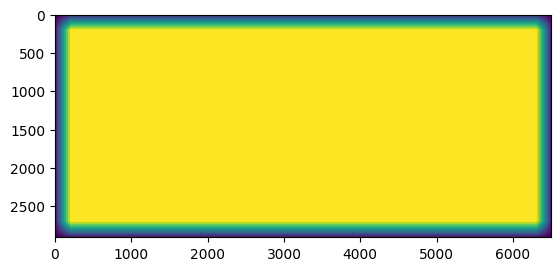

mask_count_min: 1.0


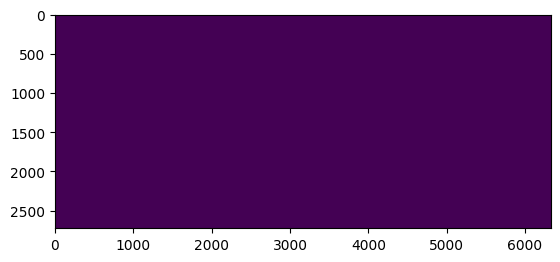

  0%|          | 2/5429 [00:00<33:25,  2.71it/s]


KeyboardInterrupt: 

In [10]:
results = []
for fragment_id in fragment_ids:
    
    test_loader, xyxys = make_test_dataset(fragment_id)
    
    binary_mask = cv2.imread(CFG.comp_dataset_path + f"test/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    # mask = mask / 255

    pad0 = (CFG.tile_size - binary_mask.shape[0] % CFG.tile_size)
    pad1 = (CFG.tile_size - binary_mask.shape[1] % CFG.tile_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
    
    mask_pred = np.zeros(binary_mask.shape)
    mask_count = np.zeros(binary_mask.shape)

    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(CFG.device)
        batch_size = images.size(0)

        with torch.no_grad():
            y_preds = model(images)

        start_idx = step * CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))
    
    plt.imshow(mask_count)
    plt.show()
    
    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    
    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]
    
    mask_pred = (mask_pred >= CFG.threshhold).astype(int)
    mask_pred *= binary_mask
    
    plt.imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    results.append((fragment_id, inklabels_rle))
    

    del mask_pred, mask_count
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
sub = pd.DataFrame(results, columns=['Id', 'Predicted'])

In [ ]:
sample_sub = pd.read_csv(CFG.comp_dataset_path + 'sample_submission.csv')
sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')

In [ ]:
sample_sub.to_csv("submission.csv", index=False)